In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import *
from pyspark.ml.regression import GBTRegressor
import numpy as np

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/07 02:47:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/07 02:47:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
df = spark.read.parquet('../data/curated/merchant_consumer_abs')

In [3]:
df

postcode,total_earners,median_age,income_sum,income_median,income_mean,2021_population,km2,persons/km2,merchant_name,revenue_level,take_rate,category,dollar_value,order_year,order_month,order_day,consumer,consumer_address,consumer_state,consumer_postcode,consumer_gender,__index_level_0__
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Et Nunc Consulting,e,0.16,books and music,342.96279330022617,2021,7,28,Peter Brennan,13276 Vazquez Rap...,NT,0800,Undisclosed,0
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Et Nunc Consulting,e,0.16,books and music,136.99894252186246,2021,7,3,Peter Brennan,13276 Vazquez Rap...,NT,0800,Undisclosed,1
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Et Nunc Consulting,e,0.16,books and music,177.75368173476977,2021,4,24,Peter Brennan,13276 Vazquez Rap...,NT,0800,Undisclosed,2
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Eros Industries,e,0.41,home and technology,479.9895071820776,2022,10,15,Peter Brennan,13276 Vazquez Rap...,NT,0800,Undisclosed,3
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Et Nunc Consulting,e,0.16,books and music,379.98044657170163,2022,8,13,Peter Brennan,13276 Vazquez Rap...,NT,0800,Undisclosed,4
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Et Nunc Consulting,e,0.16,books and music,109.58880832350144,2022,7,7,Peter Brennan,13276 Vazquez Rap...,NT,0800,Undisclosed,5
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Eros Industries,e,0.41,home and technology,68.01352266651773,2022,3,11,Peter Brennan,13276 Vazquez Rap...,NT,0800,Undisclosed,6
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Quis Turpis Corp.,e,0.48,outdoors,2385.412594085288,2021,11,28,Peter Brennan,13276 Vazquez Rap...,NT,0800,Undisclosed,7
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Et Nunc Consulting,e,0.16,books and music,100.81395268964151,2021,11,10,Peter Brennan,13276 Vazquez Rap...,NT,0800,Undisclosed,8
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Eget Metus Eu Ins...,e,0.42,fashion and acces...,213.9312766603582,2022,5,22,Corey Estrada,1703 Boyd Shore,NT,0800,Male,9


<h2>1. Split dataset</h2>

In [4]:
import time
import datetime
date = "2022-08-28" # 2022 week34
date_time = datetime.datetime.strptime(date, '%Y-%m-%d')

In [5]:
df_train = df.where((col("order_datetime") <= date_time.date()))
df_train.count()

9811158

In [6]:
df_test = df.where((col("order_datetime") > date_time.date()))
df_test.count()

1276767

<h2>2. Aggregate dataset</h2>

In [7]:
df_train_agg = df_train.groupBy(["merchant_name", "order_year", "order_month", "order_week"]).agg(
    sum("dollar_value").alias("total_revenue"), # response variable
    
    max("take_rate").alias("take_rate"),
    avg("total_earners").alias("total_earners"),
    avg("median_age").alias("median_age"),
    avg("income_median").alias("income_median"),
    avg("persons/km2").alias("population_density"),
    max("category").alias("category"),
    max("revenue_level").alias("revenue_level")
    )

df_test_agg = df_test.groupBy(["merchant_name", "order_year", "order_month", "order_week"]).agg(
    sum("dollar_value").alias("total_revenue"), # response variable

    max("take_rate").alias("take_rate"),
    avg("total_earners").alias("total_earners"),
    avg("median_age").alias("median_age"),
    avg("income_median").alias("income_median"),
    avg("persons/km2").alias("population_density"),
    max("category").alias("category"),
    max("revenue_level").alias("revenue_level")
    )

In [8]:
df_all = df.groupBy(["merchant_name", "order_year", "order_month", "order_week"]).agg(
    sum("dollar_value").alias("total_revenue"), # response variable

    max("take_rate").alias("take_rate"),
    avg("total_earners").alias("total_earners"),
    avg("median_age").alias("median_age"),
    avg("income_median").alias("income_median"),
    avg("persons/km2").alias("population_density"),
    max("category").alias("category"),
    max("revenue_level").alias("revenue_level")
    )

In [9]:
df_train_agg = df_train_agg.withColumn("revenue_taken", F.col("total_revenue") * (F.col("take_rate") / 100))
df_test_agg = df_test_agg.withColumn("revenue_taken", F.col("total_revenue") * (F.col("take_rate") / 100))
df_all = df_all.withColumn("revenue_taken", F.col("total_revenue") * (F.col("take_rate") / 100))

In [10]:
df_train_agg = df_train_agg.drop("total_revenue", "take_rate")
df_test_agg = df_test_agg.drop("total_revenue", "take_rate")
df_all = df_all.drop("total_revenue", "take_rate")

In [11]:
df_train_agg

merchant_name,order_year,order_month,total_earners,median_age,income_median,population_density,category,revenue_level,revenue_taken
A Aliquet Ltd,2021,3,4980.623604961794,45.955320262557386,44348.234836395015,446.43100140347246,home and technology,b,349.5484134530372
A Aliquet Ltd,2021,4,5354.985464077088,44.957488804012904,47087.020093628846,661.3048628221844,home and technology,b,338.07536243758386
A Aliquet Ltd,2021,7,4388.982031619088,44.56853448053012,44286.808317322975,322.56914352472995,home and technology,b,475.18502622308233
A Aliquet Ltd,2021,8,5281.06502903092,41.808178897353294,44432.17706152081,674.1575473010176,home and technology,b,375.8536740741011
A Aliquet Ltd,2021,12,4218.068045625177,44.00092016580645,45702.003770359916,633.7586224746047,home and technology,b,486.47663958043245
A Aliquet Ltd,2022,6,4907.6821031588515,44.52282551974433,46859.1278088761,506.7066383636061,home and technology,b,383.8019227224976
A Aliquet Ltd,2022,8,4587.962567801989,43.09698805802131,45936.13593995373,564.2479724970453,home and technology,b,537.5835117882583
A Arcu Industries,2021,2,3464.1233178609377,46.506422301920416,51956.04631148328,12.921544307761414,outdoors,c,21.744568393051882
A Arcu Industries,2021,12,4631.073949176494,43.00178251688292,45797.775562465315,590.2452906166948,outdoors,c,1582.2315307816057
A Arcu Industries,2022,5,4953.264665124492,41.985087824662386,46570.62536428412,839.7026423642426,outdoors,c,1203.3213130052611


In [12]:
df_train_agg.printSchema()

root
 |-- merchant_name: string (nullable = true)
 |-- order_year: integer (nullable = true)
 |-- order_month: integer (nullable = true)
 |-- total_earners: double (nullable = true)
 |-- median_age: double (nullable = true)
 |-- income_median: double (nullable = true)
 |-- population_density: double (nullable = true)
 |-- category: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- revenue_taken: double (nullable = true)



In [13]:
from xxlimited import Str
from pyspark.ml.feature import OneHotEncoder, StringIndexer

stringIndexer = StringIndexer(inputCols=["category", "revenue_level"], outputCols=["category_num", "revenue_num"])
model = stringIndexer.fit(df_train_agg)
train1 = model.transform(df_train_agg)

model = stringIndexer.fit(df_test_agg)
test1 = model.transform(df_test_agg)


In [14]:

encoder = OneHotEncoder(inputCols=["category_num", "revenue_num"], outputCols=["category_vec", "revenue_vec"])
train = encoder.fit(train1).transform(train1).drop("category_num", "revenue_num")
test = encoder.fit(test1).transform(test1).drop("category_num", "revenue_num")


In [15]:
train

merchant_name,order_year,order_month,total_earners,median_age,income_median,population_density,category,revenue_level,revenue_taken,category_vec,revenue_vec
A Aliquet Ltd,2021,3,4980.623604961794,45.955320262557386,44348.234836395015,446.43100140347246,home and technology,b,349.5484134530372,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2021,4,5354.985464077088,44.957488804012904,47087.020093628846,661.3048628221844,home and technology,b,338.07536243758386,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2021,7,4388.982031619088,44.56853448053012,44286.808317322975,322.56914352472995,home and technology,b,475.18502622308233,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2021,8,5281.06502903092,41.808178897353294,44432.17706152081,674.1575473010176,home and technology,b,375.8536740741011,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2021,12,4218.068045625177,44.00092016580645,45702.003770359916,633.7586224746047,home and technology,b,486.47663958043245,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2022,6,4907.6821031588515,44.52282551974433,46859.1278088761,506.7066383636061,home and technology,b,383.8019227224976,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2022,8,4587.962567801989,43.09698805802131,45936.13593995373,564.2479724970453,home and technology,b,537.5835117882583,"(4,[0],[1.0])","(4,[1],[1.0])"
A Arcu Industries,2021,2,3464.1233178609377,46.506422301920416,51956.04631148328,12.921544307761414,outdoors,c,21.744568393051882,"(4,[2],[1.0])","(4,[2],[1.0])"
A Arcu Industries,2021,12,4631.073949176494,43.00178251688292,45797.775562465315,590.2452906166948,outdoors,c,1582.2315307816057,"(4,[2],[1.0])","(4,[2],[1.0])"
A Arcu Industries,2022,5,4953.264665124492,41.985087824662386,46570.62536428412,839.7026423642426,outdoors,c,1203.3213130052611,"(4,[2],[1.0])","(4,[2],[1.0])"


In [16]:
# vectorized the features for model training
from pyspark.ml.feature import VectorAssembler

features = 'features'
internal_cols = ["order_year", "order_month", "order_week", "category_vec", "revenue_vec"]
external_cols = ["total_earners", "median_age", "income_median", "population_density"]

assembler = VectorAssembler(
    # which column to combine
    inputCols=internal_cols, 
    # How should the combined columns be named
    outputCol="internal"
)
train = assembler.transform(train.dropna('any'))
test = assembler.transform(test.dropna('any'))

assembler = VectorAssembler(
    # which column to combine
    inputCols=external_cols, 
    # How should the combined columns be named
    outputCol="external"
)
train = assembler.transform(train.dropna('any'))
test = assembler.transform(test.dropna('any'))

In [17]:
from pyspark.ml.feature import Interaction

interaction1 = Interaction(inputCols=internal_cols, outputCol="internal_interact")
train = interaction1.transform(train)
test = interaction1.transform(test)

In [18]:
train.select("internal_interact", "internal").show(truncate=False)

+-------------------+------------------------------------+
|internal_interact  |internal                            |
+-------------------+------------------------------------+
|(16,[1],[6063.0])  |(10,[0,1,2,7],[2021.0,3.0,1.0,1.0]) |
|(16,[1],[8084.0])  |(10,[0,1,2,7],[2021.0,4.0,1.0,1.0]) |
|(16,[1],[14147.0]) |(10,[0,1,2,7],[2021.0,7.0,1.0,1.0]) |
|(16,[1],[16168.0]) |(10,[0,1,2,7],[2021.0,8.0,1.0,1.0]) |
|(16,[1],[24252.0]) |(10,[0,1,2,7],[2021.0,12.0,1.0,1.0])|
|(16,[1],[12132.0]) |(10,[0,1,2,7],[2022.0,6.0,1.0,1.0]) |
|(16,[1],[16176.0]) |(10,[0,1,2,7],[2022.0,8.0,1.0,1.0]) |
|(16,[10],[4042.0]) |(10,[0,1,4,8],[2021.0,2.0,1.0,1.0]) |
|(16,[10],[24252.0])|(10,[0,1,4,8],[2021.0,12.0,1.0,1.0])|
|(16,[10],[10110.0])|(10,[0,1,4,8],[2022.0,5.0,1.0,1.0]) |
|(16,[10],[12132.0])|(10,[0,1,4,8],[2022.0,6.0,1.0,1.0]) |
|(16,[14],[16176.0])|(10,[0,1,5,8],[2022.0,8.0,1.0,1.0]) |
|(16,[6],[14147.0]) |(10,[0,1,3,8],[2021.0,7.0,1.0,1.0]) |
|(16,[6],[20210.0]) |(10,[0,1,3,8],[2021.0,10.0,1.0,1.0]

In [19]:
from pyspark.ml.feature import Interaction

interaction2 = Interaction(inputCols=["internal", "external"], outputCol="external_interact")
train = interaction2.transform(train)
test = interaction2.transform(test)

In [20]:
assembler1 = VectorAssembler(
    # which column to combine
    inputCols=external_cols + internal_cols, 
    # How should the combined columns be named
    outputCol="feature_additive"
)

train = assembler1.transform(train)
test = assembler1.transform(test)

In [21]:

assembler2 = VectorAssembler(
    # which column to combine
    inputCols=external_cols + internal_cols + ["internal_interact"], 
    # How should the combined columns be named
    outputCol="feature_internal"
)

train = assembler2.transform(train)
test = assembler2.transform(test)

In [22]:
assembler3 = VectorAssembler(
    # which column to combine
    inputCols=external_cols + internal_cols + ["internal_interact"] + ["external_interact"], 
    # How should the combined columns be named
    outputCol="feature_all"
)

train = assembler3.transform(train)
test = assembler3.transform(test)

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_real_vs_pred(model_name, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.concat([y_real, y_pred], axis = 1)
    reg_real_vs_pred = reg_real_vs_pred.head(60)
    reg_real_vs_pred.plot(kind='bar', title='MODEL: '+model_name, figsize=(16,5))
    plt.show()

## 3. Gradient Boost Tree

In [24]:
from pyspark.ml.regression import GBTRegressor

# Define Gradient boosted tree regression algorithm
rf_additive = GBTRegressor(maxDepth=6, 
                            featuresCol='feature_additive', 
                            labelCol='revenue_taken',
                            ).fit(train)

rf_internal = GBTRegressor(maxDepth=6, 
                  featuresCol='feature_internal', 
                  labelCol='revenue_taken',
                  ).fit(train)

rf_all = GBTRegressor(maxDepth=7, 
                  featuresCol='feature_all', 
                  labelCol='revenue_taken',
                  ).fit(train)

In [25]:
predictions_additive = rf_additive.transform(test)
predictions_internal = rf_internal.transform(test)
predictions_all = rf_all.transform(test)

In [26]:
from pyspark.ml.evaluation import RegressionEvaluator
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="revenue_taken",
                                predictionCol="prediction",
                                metricName="rmse")


rmse_addtive = evaluator.evaluate(predictions_additive)
rmse_internal = evaluator.evaluate(predictions_internal)
rmse_all = evaluator.evaluate(predictions_all)
print("Root Mean Squared Error (RMSE) for additive model = %g" % rmse_addtive)
print("Root Mean Squared Error (RMSE) for internal interaction model = %g" % rmse_internal)
print("Root Mean Squared Error (RMSE) for full model = %g" % rmse_all)

22/10/06 18:43:18 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/06 18:43:18 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Root Mean Squared Error (RMSE) for additive model = 1875.74
Root Mean Squared Error (RMSE) for internal interaction model = 1885.05
Root Mean Squared Error (RMSE) for full model = 1881.17


In [27]:
y_true_additive = predictions_additive.select("revenue_taken").toPandas()
y_pred_additive = predictions_additive.select("prediction").toPandas()

y_true_internal = predictions_internal.select("revenue_taken").toPandas()
y_pred_internal = predictions_internal.select("prediction").toPandas()

y_true_all = predictions_all.select("revenue_taken").toPandas()
y_pred_all = predictions_all.select("prediction").toPandas()

import sklearn.metrics
r2_score_additive = sklearn.metrics.r2_score(y_true_additive, y_pred_additive)
r2_score_internal = sklearn.metrics.r2_score(y_true_internal, y_pred_internal)
r2_score_all = sklearn.metrics.r2_score(y_true_all, y_pred_all)
print('r2_score_additive: {:4.3f}'.format(r2_score_additive))
print('r2_score_internal: {:4.3f}'.format(r2_score_internal))
print('r2_score_all: {:4.3f}'.format(r2_score_all))

r2_score_additive: 0.382
r2_score_internal: 0.376
r2_score_all: 0.378


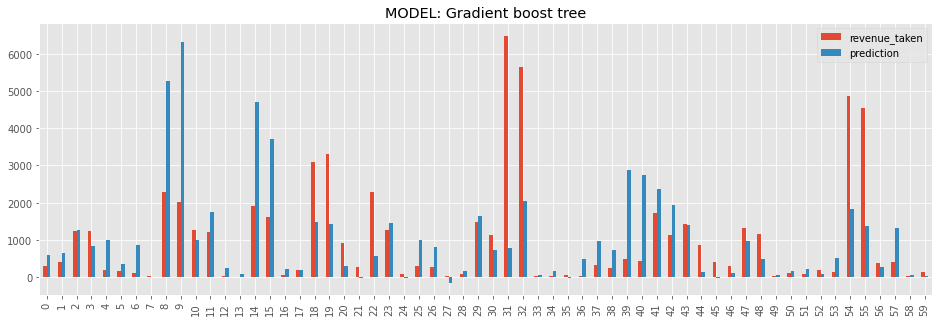

In [28]:
plot_real_vs_pred("Gradient boost tree", y_true_all, y_pred_all)

## 4. Random Forest Regressor

In [29]:
# Import Random Forest Regressor
from pyspark.ml.regression import RandomForestRegressor


rfR_additive = RandomForestRegressor(maxDepth=6, 
                  featuresCol='feature_additive', 
                  labelCol='revenue_taken',
                  ).fit(train)

rfR_internal = RandomForestRegressor(maxDepth=6, 
                  featuresCol='feature_internal', 
                  labelCol='revenue_taken',
                  ).fit(train)

rfR_all = RandomForestRegressor(maxDepth=7, 
                  featuresCol='feature_all', 
                  labelCol='revenue_taken',
                  ).fit(train)

In [30]:
predictions_additive_R = rfR_additive.transform(test)
predictions_internal_R = rfR_internal.transform(test)
predictions_all_R = rfR_all.transform(test)

In [31]:
rmse_addtive_R = evaluator.evaluate(predictions_additive_R)
rmse_internal_R = evaluator.evaluate(predictions_internal_R)
rmse_all_R = evaluator.evaluate(predictions_all_R)
print("Root Mean Squared Error (RMSE) for additive model = %g" % rmse_addtive_R)
print("Root Mean Squared Error (RMSE) for internal interaction model = %g" % rmse_internal_R)
print("Root Mean Squared Error (RMSE) for full model = %g" % rmse_all_R)

Root Mean Squared Error (RMSE) for additive model = 2065.82
Root Mean Squared Error (RMSE) for internal interaction model = 2078.08
Root Mean Squared Error (RMSE) for full model = 1970.3


In [32]:
y_true_additive_R = predictions_additive_R.select("revenue_taken").toPandas()
y_pred_additive_R = predictions_additive_R.select("prediction").toPandas()

y_true_internal_R = predictions_internal_R.select("revenue_taken").toPandas()
y_pred_internal_R = predictions_internal_R.select("prediction").toPandas()

y_true_all_R = predictions_all_R.select("revenue_taken").toPandas()
y_pred_all_R = predictions_all_R.select("prediction").toPandas()


r2_score_additive_R = sklearn.metrics.r2_score(y_true_additive_R, y_pred_additive_R)
r2_score_internal_R = sklearn.metrics.r2_score(y_true_internal_R, y_pred_internal_R)
r2_score_all_R = sklearn.metrics.r2_score(y_true_all_R, y_pred_all_R)
print('r2_score_additive: {:4.3f}'.format(r2_score_additive_R))
print('r2_score_internal: {:4.3f}'.format(r2_score_internal_R))
print('r2_score_all: {:4.3f}'.format(r2_score_all_R))

r2_score_additive: 0.250
r2_score_internal: 0.242
r2_score_all: 0.318


## 5. Transform the total revenue to score

In [55]:
df_all

merchant_name,order_year,order_month,total_earners,median_age,income_median,population_density,category,revenue_level,revenue_taken
A Aliquet Ltd,2021,3,4980.623604961794,45.955320262557386,44348.234836395015,446.43100140347246,home and technology,b,349.5484134530372
A Aliquet Ltd,2021,4,5354.985464077088,44.957488804012904,47087.020093628846,661.3048628221844,home and technology,b,338.07536243758386
A Aliquet Ltd,2021,7,4388.982031619088,44.56853448053012,44286.808317322975,322.56914352472995,home and technology,b,475.18502622308233
A Aliquet Ltd,2021,8,5281.06502903092,41.808178897353294,44432.17706152081,674.1575473010176,home and technology,b,375.8536740741011
A Aliquet Ltd,2021,12,4218.068045625177,44.00092016580645,45702.003770359916,633.7586224746047,home and technology,b,486.47663958043245
A Aliquet Ltd,2022,6,4907.6821031588515,44.52282551974433,46859.1278088761,506.7066383636061,home and technology,b,383.8019227224976
A Aliquet Ltd,2022,8,4587.962567801989,43.09698805802131,45936.13593995373,564.2479724970453,home and technology,b,537.5835117882583
A Arcu Industries,2021,2,3464.1233178609377,46.506422301920416,51956.04631148328,12.921544307761414,outdoors,c,21.744568393051882
A Arcu Industries,2021,12,4631.073949176494,43.00178251688292,45797.775562465315,590.2452906166948,outdoors,c,1582.2315307816057
A Arcu Industries,2022,5,4953.264665124492,41.985087824662386,46570.62536428412,839.7026423642426,outdoors,c,1203.3213130052611


In [56]:
revenue_score = df_all.groupBy(["merchant_name"]).agg(
    sum("revenue_taken").alias("total_revenue")
    )

In [57]:
revenue_score.orderBy("total_revenue")

merchant_name,total_revenue
Consectetuer Ipsu...,3.250765585109828
Faucibus Ltd,3.5512344419012583
Ac Eleifend Vitae...,3.9167039023366743
Velit Inc.,5.111416773814975
Magna Sed Associates,6.039746046534802
Egestas A Dui Corp.,6.268172996821954
Nulla Limited,6.881752409537095
Enim Etiam Institute,7.9729906258318834
Lacus LLP,8.263656555885825
Orci Ut Institute,9.0989169302811


In [58]:
revenue_score = revenue_score.withColumn("a", lit("a"))

In [59]:
from pyspark.sql.window import Window
from pyspark.sql.functions import percent_rank

In [60]:
# Use the rank as the score
Window_Spec  = Window.partitionBy("a").orderBy("total_revenue")
revenue_score = revenue_score.withColumn("percent_rank", percent_rank().over(Window_Spec)) 


In [61]:
revenue_score

merchant_name,total_revenue,a,percent_rank
Consectetuer Ipsu...,3.250765585109828,a,0.0
Faucibus Ltd,3.5512344419012583,a,2.569373072970195...
Ac Eleifend Vitae...,3.9167039023366743,a,5.138746145940391E-4
Velit Inc.,5.111416773814975,a,7.708119218910585E-4
Magna Sed Associates,6.039746046534802,a,0.001027749229188...
Egestas A Dui Corp.,6.268172996821954,a,0.001284686536485...
Nulla Limited,6.881752409537095,a,0.001541623843782117
Enim Etiam Institute,7.9729906258318834,a,0.001798561151079...
Lacus LLP,8.263656555885825,a,0.002055498458376...
Orci Ut Institute,9.0989169302811,a,0.002312435765673...


In [62]:
revenue_score = revenue_score.withColumn("revenue_score", F.col("percent_rank")).drop("a","percent_rank", "total_revenue")

#### Add variance as one metrics

In [63]:
df_variance = df.groupBy(["merchant_name"]).agg(
    variance("dollar_value").alias("variance")
    )

In [64]:
df_variance = df_variance.fillna(value = 0)

In [65]:
from pyspark.ml.feature import StandardScaler


# VectorAssembler Transformation - Converting column to vector type
assembler_vec = VectorAssembler(inputCols=["variance"],outputCol="variance_Vect")
variance_score = assembler_vec.transform(df_variance)

scaler = StandardScaler(inputCol="variance_Vect", outputCol="variance_score",
                        withStd=True, withMean=False)


# Standardise the trend score (since it contain negative value) as score

from pyspark.ml.functions import vector_to_array
variance_score = scaler.fit(variance_score).transform(variance_score).drop("variance","variance_Vect").withColumn("variance_score", vector_to_array("variance_score")[0])


In [66]:
variance_score = variance_score.withColumnRenamed("merchant_name", "name")

revenue_score = revenue_score.join(variance_score, variance_score.name ==  revenue_score.merchant_name,"inner").drop("name")

In [68]:
revenue_score

Exception in thread "serve-GetRows" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


merchant_name,revenue_score,variance_score
Consectetuer Ipsu...,0.0,0.0
Faucibus Ltd,2.569373072970195...,0.0
Ac Eleifend Vitae...,5.138746145940391E-4,0.0
Velit Inc.,7.708119218910585E-4,0.0
Magna Sed Associates,0.001027749229188...,0.0
Egestas A Dui Corp.,0.001284686536485...,0.0
Nulla Limited,0.001541623843782117,0.0
Enim Etiam Institute,0.001798561151079...,1.9482026156202967
Lacus LLP,0.002055498458376...,0.6381667845627906
Orci Ut Institute,0.002312435765673...,1.4613814191387127


#### Combined with train score

In [69]:
trend = spark.read.option("header", "true").csv("../data/curated/increasing.csv")

In [70]:
trend = trend.withColumn("increasing", F.col("increasing").cast("double"))

In [71]:
trend

merchant_name,increasing
Eros Non LLP,-980.0837015305178
Tortor Integer Al...,-349.3538636710657
Sodales Limited,-9654.404131067335
Nulla At Sem Limited,-1190.5132491448949
Elementum Dui Ass...,3655.7094516963953
Duis Elementum Corp.,3651.7105101416964
Vel Quam Industries,2727.648449189126
Velit Institute,3164.4211675338756
Dui Limited,1099.1811736678892
Enim Mi Institute,-27943.28252906102


In [72]:
from pyspark.ml.feature import StandardScaler


# VectorAssembler Transformation - Converting column to vector type
assembler_vec = VectorAssembler(inputCols=["increasing"],outputCol="increasing_Vect")
trend_score = assembler_vec.transform(trend)

scaler = StandardScaler(inputCol="increasing_Vect", outputCol="trend_score",
                        withStd=True, withMean=False)


# Standardise the trend score (since it contain negative value) as score

from pyspark.ml.functions import vector_to_array
trend_score = scaler.fit(trend_score).transform(trend_score).drop("increasing","increasing_Vect").withColumn("trend_score", vector_to_array("trend_score")[0])



In [73]:
trend_score = trend_score.withColumnRenamed("merchant_name", "name")

In [74]:
trend_revenue_final = revenue_score.join(trend_score, trend_score.name ==  revenue_score.merchant_name,"inner").drop("name")

In [75]:
trend_revenue_final

merchant_name,revenue_score,variance_score,trend_score
Consectetuer Ipsu...,0.0,0.0,0.012512970918944816
Faucibus Ltd,2.569373072970195...,0.0,-0.01196818716621...
Ac Eleifend Vitae...,5.138746145940391E-4,0.0,0.011023550264931004
Velit Inc.,7.708119218910585E-4,0.0,-0.00796371495021574
Magna Sed Associates,0.001027749229188...,0.0,0.013174105188561047
Egestas A Dui Corp.,0.001284686536485...,0.0,-0.07457649838314082
Nulla Limited,0.001541623843782117,0.0,-0.03087919316331...
Enim Etiam Institute,0.001798561151079...,1.9482026156202967,-0.3129278634926591
Lacus LLP,0.002055498458376...,0.6381667845627906,0.18884255396835822
Orci Ut Institute,0.002312435765673...,1.4613814191387127,0.23816250779671555


In [76]:
trend_revenue_final.count()

3893

In [ ]:
trend_revenue_final.write.parquet("../data/curated/revenue_trend_score")